# Appendix
## Implementation Adaptive PCA and Image denoising

In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from measure import compute_psnr, compute_ssim
from utils import add_noisy, transform_wavelet
from config import list_survey
from PIL import Image
import os
from glob import glob

In [2]:
_IMG_PATH = '../images/lena512.bmp'
_OUT_PATH = '../outputs'
_LOG_PATH = '../logs'

In [3]:
img = cv2.imread(_IMG_PATH)

In [4]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_origin = img_gray

In [6]:
def divide_patches(I, patch_size = (7,7)):
    """
    I is the image function
    """
    patches_array = np.lib.stride_tricks.sliding_window_view(I, (7,7))
    patches_array_rot = np.moveaxis(patches_array, 0, 1)
    training_region = patches_array_rot.reshape(
                                (patches_array_rot.shape[0]*patches_array_rot.shape[1],
                                 patches_array_rot.shape[2]*patches_array_rot.shape[3]))
    return training_region

In [7]:
def define_centroid_patches(hyper_params, I):
    """
    I is the image function
    """
    ## define size of mask follow size of feature map
    ## mask is the array of centroids of patches
    centroids_width = int((I.shape[0] - hyper_params['patch_size'])/hyper_params['stride_overlap']) + 1
    centroids_height = int((I.shape[1] - hyper_params['patch_size'])/hyper_params['stride_overlap']) + 1
    total_num_centroids = centroids_width*centroids_height
    
    ## define index matrix of the centroids array
    centroids_map_index = np.arange(total_num_centroids)
    centroids_map_index = centroids_map_index.reshape((centroids_height, centroids_width)).T
    
    return centroids_map_index, centroids_width, centroids_height

In [8]:
def get_principal_components(centroids_map_index, 
                      training_region, 
                      current_row, 
                      current_col,
                      current_centroid_idx,
                      hyper_params):
    
    [centroids_width, centroids_height] = centroids_map_index.shape

    rmin = max(current_row - hyper_params['train_region_size'] - 1, 0)
    rmax = min(current_row + hyper_params['train_region_size'], centroids_width)
    cmin = max(current_col - hyper_params['train_region_size'] - 1, 0)
    cmax = min(current_col + hyper_params['train_region_size'], centroids_height)

    idx = centroids_map_index[rmin: rmax, cmin: cmax]
    idx = (idx.T).flatten()
    
    ## training_region has size of 506*506*7*7
    ## training_set has size 21*21*7*7
    training_set = training_region[idx,:]
    
    ## denoise_region is signal with noise in middle 7*7
    denoise_region = training_region[current_centroid_idx,:]
    
    ## calculate distance to selecting principal components
    init_distance = (training_set[:, 0] - denoise_region[0])**2
    init_distance = init_distance.reshape((init_distance.shape[0], 1))

    for k in range(1, training_region.shape[1]):
        partial_distance = (training_set[:, k] - denoise_region[k])**2
        partial_distance = partial_distance.reshape((partial_distance.shape[0], 1))
        init_distance += partial_distance

    components_distance = init_distance/training_region.shape[1]
    components_distance_sort = np.argsort(components_distance, axis=0)
    
    pc_index = idx[components_distance_sort[0:hyper_params['n_components']]]

    return pc_index

In [9]:
def pca_transform(x):
    """
    tranform from spatial domain to PCA domain
    param:
        x: MxN matrix (M dimensions, N trials)
    return:
        y: y=p*x
        p: the transform matrix
        v: the variance vector
    """
    [m, n] = x.shape
    
    ## shift data to the center (subtract mean from every dimension)
    mean_x = (np.mean(x, axis=1)).reshape((m, 1))
    x = x - mean_x

    covar_x = np.matmul(x,x.T)/(n-1)
    
    ## compute covariance matrix S for centered data 
    ## and find it eigenvectors b and eigenvalues λ.
    [variance, transform_mat]= np.linalg.eig(covar_x)
    
    ## sort eigenvectors by corresponding eigenvalues in descending order
    var_minus = -1 * variance
    ind = np.argsort(var_minus, axis=0)

    variance = variance[ind];
    transform_mat = transform_mat[:, ind]

    transform_mat = transform_mat.T
    transform_coef = np.matmul(transform_mat, x)

    return [transform_coef, transform_mat, variance, mean_x]

In [10]:
def adapt_pc_denoising(img_origin, img_noise, hyper_params):
    
    y_coeffs = transform_wavelet(img_noise)
    var_noise_est = np.median(np.abs(y_coeffs[-1][-1]))/0.6745
    
    centroids_map_index, centroids_width, centroids_height = define_centroid_patches(hyper_params, img_noise)
    training_region = divide_patches(img_noise)
    denoise_set = np.zeros(training_region.T.shape)

    print('*'*10,'Training','*'*10)
    with tqdm(total = centroids_width * centroids_height) as pbar:
        for i in range(centroids_width):
            for j in range(centroids_height):

                current_row = i
                current_col = j

                current_centroid_idx = current_col*centroids_width + current_row

                pc_idx = get_principal_components(centroids_map_index, 
                              training_region, 
                              current_row, 
                              current_col,
                              current_centroid_idx,
                              hyper_params)

                pc_idx = pc_idx.flatten()

                [transform_coef, transform_mat, variance, mean_x] = pca_transform(training_region.T[:, pc_idx])

                py = np.mean(transform_coef**2, axis=1)
                py = py.reshape((py.shape[0], 1))

                ## The variance of xi is estimated using the maximum likelihood estimator
                px = np.maximum(np.zeros(py.shape), py - var_noise_est**2)

                ## The LMMSE estimator for xi is xi = k*yi
                wei = px/py

                ## PCA inverse transformation 
                trans_coeff_est = ((transform_coef[:, 0]).T * (wei.T)).T
                denoise_est = np.matmul(transform_mat.T, trans_coeff_est)
                mean_x_reshape = mean_x[:, 0].reshape((mean_x[:, 0].shape[0], 1))

                denoise_set[:, current_centroid_idx] = (denoise_est + mean_x_reshape)[:, 0]
                pbar.update(1)

    print('*'*10,'Reconstructing','*'*10)
    img_recon = np.zeros(img_noise.shape)
    img_wei = np.zeros(img_noise.shape)
    row_idx = np.arange(0, centroids_width, 1)
    col_idx = np.arange(0, centroids_height, 1)

    k = 0
    for i in range(hyper_params['patch_size']):
        for j in range(hyper_params['patch_size']):
            rv, cv = np.meshgrid(row_idx+i, col_idx+j)
            img_recon[rv, cv] = img_recon[rv, cv] + (denoise_set[k, :].T).reshape((centroids_width, centroids_height))
            img_wei[rv, cv] = img_wei[rv, cv] + 1
            k+=1
    img_denoise = img_recon/(img_wei)
    
    compare_psnr = (compute_psnr(img_gray, img_noise), compute_psnr(img_gray, img_denoise))
    compare_ssim = (compute_ssim(img_gray, img_noise), compute_ssim(img_gray, img_denoise))
    
    return img_denoise, compare_psnr, compare_ssim

In [11]:
# plt.imshow(img_denoise, cmap='gray')

In [16]:
count = 0
for hyper_param in list_survey[1:]:
    print('='*20, str(count) + '/' + str(len(list_survey)), '='*20)
    img_noise, noise = add_noisy(img_gray, var=hyper_param['var_noise']**2)
    img_denoise, compare_psnr, compare_ssim = adapt_pc_denoising(img_origin, img_noise, hyper_param)
    
    img_denoise_format_int = (((img_denoise - img_denoise.min()) / (img_denoise.max() - img_denoise.min())) * 255.9).astype(np.uint8)
    img_denoise_array = Image.fromarray(img_denoise_format_int)
    img_save_name = 'vnoise' + '_' + str(hyper_param['var_noise']) + '_' + 'npc' + '_' + str(hyper_param['n_components']) + '.png'
    img_denoise_array.save(os.path.join(_OUT_PATH,img_save_name).replace('\\','/'))
    
    log_save_name = 'vnoise' + '_' + str(hyper_param['var_noise']) + '_' + 'npc' + '_' + str(hyper_param['n_components']) + '.npy'
    measures = []
    measures.append(compare_psnr[0])
    measures.append(compare_psnr[1])
    measures.append(compare_ssim[0])
    measures.append(compare_ssim[1])
    measure_array = np.array(measures)
    log_file = open(os.path.join(_LOG_PATH,log_save_name).replace('\\','/'),'wb')
    np.save(log_file,measure_array)
    
    count+=1

==================== 0/16 ====================
********** Training **********


100%|██████████| 256036/256036 [07:51<00:00, 542.73it/s]


********** Reconstructing **********
==================== 1/16 ====================
********** Training **********


100%|██████████| 256036/256036 [08:24<00:00, 507.03it/s]


********** Reconstructing **********
==================== 2/16 ====================
********** Training **********


100%|██████████| 256036/256036 [08:25<00:00, 506.71it/s]


********** Reconstructing **********
==================== 3/16 ====================
********** Training **********


100%|██████████| 256036/256036 [09:13<00:00, 462.81it/s]


********** Reconstructing **********
==================== 4/16 ====================
********** Training **********


100%|██████████| 256036/256036 [09:05<00:00, 468.95it/s]


********** Reconstructing **********
==================== 5/16 ====================
********** Training **********


100%|██████████| 256036/256036 [09:18<00:00, 458.41it/s]


********** Reconstructing **********
==================== 6/16 ====================
********** Training **********


100%|██████████| 256036/256036 [09:32<00:00, 447.55it/s]


********** Reconstructing **********
==================== 7/16 ====================
********** Training **********


100%|██████████| 256036/256036 [07:27<00:00, 572.02it/s]


********** Reconstructing **********
==================== 8/16 ====================
********** Training **********


100%|██████████| 256036/256036 [07:40<00:00, 555.45it/s]


********** Reconstructing **********
==================== 9/16 ====================
********** Training **********


100%|██████████| 256036/256036 [08:24<00:00, 507.92it/s]


********** Reconstructing **********
==================== 10/16 ====================
********** Training **********


100%|██████████| 256036/256036 [08:55<00:00, 477.95it/s]


********** Reconstructing **********
==================== 11/16 ====================
********** Training **********


100%|██████████| 256036/256036 [08:27<00:00, 504.93it/s]


********** Reconstructing **********
==================== 12/16 ====================
********** Training **********


100%|██████████| 256036/256036 [10:05<00:00, 422.77it/s]


********** Reconstructing **********
==================== 13/16 ====================
********** Training **********


100%|██████████| 256036/256036 [09:23<00:00, 454.34it/s]


********** Reconstructing **********
==================== 14/16 ====================
********** Training **********


100%|██████████| 256036/256036 [10:50<00:00, 393.54it/s]


********** Reconstructing **********


In [28]:
list_measures_25 = glob('../logs/*_25_*.npy')
list_measures_50 = glob('../logs/*_50_*.npy')

list_psnr_25 = []
list_ssim_25 = []
list_psnr_50 = []
list_ssim_50 = []
for m_file in list_measures_25:
    m_file = m_file.replace('\\','/')
    measure = np.load(m_file)
    psnr, ssim = measure[1], measure[3]
    list_psnr_25.append(psnr)
    list_ssim_25.append(ssim)

for m_file in list_measures_50:
    m_file = m_file.replace('\\','/')
    measure = np.load(m_file)
    psnr, ssim = measure[1], measure[3]
    list_psnr_50.append(psnr)
    list_ssim_50.append(ssim)

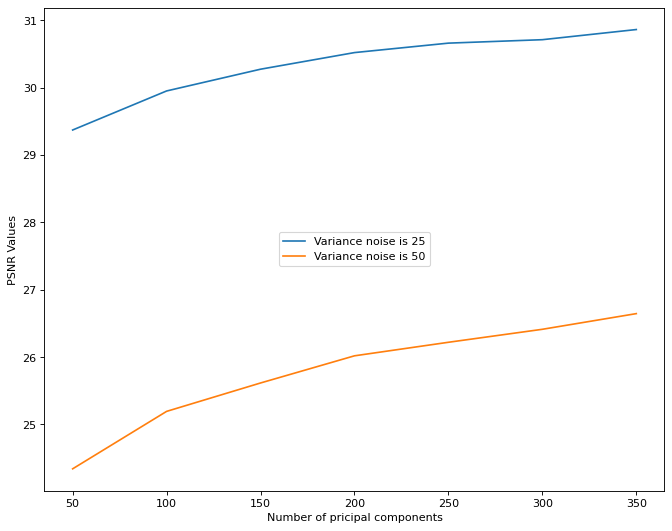

In [31]:
plt.figure(figsize=(10, 8), dpi=80)
# plt.ylim(0,0.6)
plt.plot(range(50,400,50),list_psnr_25[:-1])
plt.plot(range(50,400,50),list_psnr_50[:-1])
plt.legend(['Variance noise is 25','Variance noise is 50'], loc='center')
plt.xlabel('Number of pricipal components')
plt.ylabel('PSNR Values')
plt.savefig('../outputs/psnr_per_npc.png')
# plt.show()

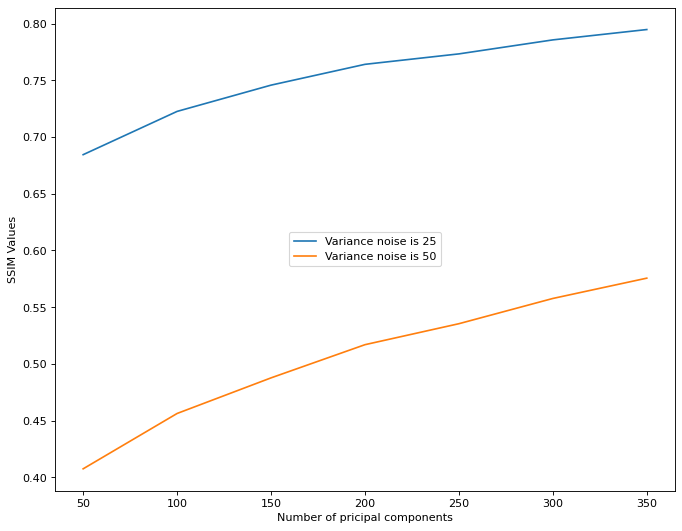

In [30]:
plt.figure(figsize=(10, 8), dpi=80)
# plt.ylim(0,0.6)
plt.plot(range(50,400,50),list_ssim_25[:-1])
plt.plot(range(50,400,50),list_ssim_50[:-1])
plt.legend(['Variance noise is 25','Variance noise is 50'], loc='center')
plt.xlabel('Number of pricipal components')
plt.ylabel('SSIM Values')
# plt.savefig('../outputs/compare_methods_var_noise_estimation.png')
plt.show()

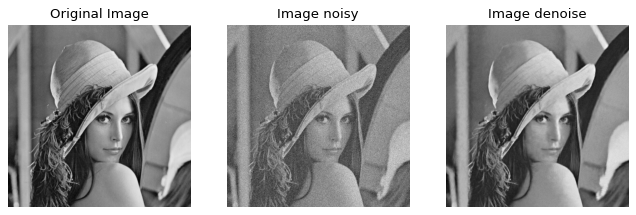

In [33]:
plt.figure(figsize=(10, 8), dpi=80)

plt.subplot(1, 3, 1)
plt.imshow(img_origin,cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
img_noise, noise = add_noisy(img_gray, var=25**2)
plt.imshow(img_noise,cmap='gray')
plt.title("Image noisy")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.imread('../outputs/vnoise_25_npc_350.png'),cmap='gray')
plt.title("Image denoise")
plt.axis('off')

plt.savefig('../outputs/npc_350_var_25.png')

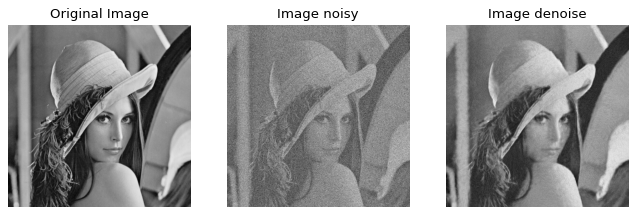

In [36]:
plt.figure(figsize=(10, 8), dpi=80)

plt.subplot(1, 3, 1)
plt.imshow(img_origin,cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
img_noise, noise = add_noisy(img_gray, var=50**2)
plt.imshow(img_noise,cmap='gray')
plt.title("Image noisy")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.imread('../outputs/vnoise_50_npc_350.png'),cmap='gray')
plt.title("Image denoise")
plt.axis('off')

plt.savefig('../outputs/npc_350_var_50.png')